In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

Welcome to JupyROOT 6.18/00


In [5]:
outstr = '100_500ps_selection'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/05_08_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')            

# Prepare time data for the minimization

In [6]:
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]

In [10]:
dict_df_energy = {}

for energy in energies:
    round_energy = round(float(energy),-1)
    if round_energy ==240 : round_energy = 250
        
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
        pos_cut = 4
    data = []
    for evt in tree:
        if evt.fit_ampl[getattr(evt, crystal)]>1000 and evt.fit_ampl[evt.MCP1]>100 and evt.fit_ampl[evt.MCP2]>100 and evt.n_tracks==1 and abs(evt.X[0]-dict_crystal_centers[crystal][0])<pos_cut and abs(evt.Y[0]-dict_crystal_centers[crystal][1])<pos_cut : 
            evt_dict = {}
            evt_dict['Energy'] = evt.Energy
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            for xstal in ['C3']:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['dt_ecal_mcp1_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_ecal_mcp2_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
                evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
    
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%s.csv'%(trees_path,round_energy)
    df.to_csv(pd_name)


Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available


In [7]:
dict_df_energy = {}
#Event selection
for energy in energies:
    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%s.csv'%(trees_path,energy)
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

## Event selection

In [8]:
dt_cut = 500
#Event selection
for energy in energies:
    df = dict_df_energy[energy]
    dict_df_energy[energy] = df.loc[(df.dt_ecal_mcp1_C3<df['dt_ecal_mcp1_C3'].mean()+dt_cut) & (df.dt_ecal_mcp1_C3>df['dt_ecal_mcp1_C3'].mean()-dt_cut) 
      & (df.dt_ecal_mcp2_C3<df['dt_ecal_mcp2_C3'].mean()+dt_cut) & (df.dt_ecal_mcp2_C3>df['dt_ecal_mcp2_C3'].mean()-dt_cut) 
      & (df.dt_mcp2_mcp1_C3<df['dt_mcp2_mcp1_C3'].mean()+dt_cut) & (df.dt_mcp2_mcp1_C3>df['dt_mcp2_mcp1_C3'].mean()-dt_cut)]

In [9]:
gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')


0

In [10]:
results_params = {}
for energy in energies:
    print 'Analyzing energy ',energy
    df = dict_df_energy[energy]
    time_minimizer = ROOT.LLminimizer(df['fit_ampl_MCP1'].shape[0],array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])),array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),array('d',list(df['dt_mcp2_mcp1_C3'])),crystal,energy)
    time_minimizer.MinimizeNLL()
    res = {}
    res['Cm'] = [time_minimizer.m_Cm_,time_minimizer.m_Cm_e_]
    res['a1'] = [time_minimizer.m_a1_,time_minimizer.m_a1_e_]
    res['b1'] = [time_minimizer.m_b1_,time_minimizer.m_b1_e_]
    res['a2'] = [time_minimizer.m_a2_,time_minimizer.m_a2_e_]
    res['b2'] = [time_minimizer.m_b2_,time_minimizer.m_b2_e_]
    res['alpha'] = [time_minimizer.m_alpha_,time_minimizer.m_alpha_e_]
    res['beta'] = [time_minimizer.m_beta_,time_minimizer.m_beta_e_]
    res['gamma'] = [time_minimizer.m_gamma_,time_minimizer.m_gamma_e_]        
    results_params[energy] = res


Analyzing energy  49.99
Analyzing energy  99.83
Analyzing energy  149.12
Analyzing energy  197.27
Analyzing energy  243.48


In [11]:
#print results_params
cm_res = array('d')
energies_float = array('d')
cm_e_res = array('d')
energies_float_e = array('d')

beam_scan_resolution = 0.005

for energy in energies:
    cm_res.append(results_params[energy]['Cm'][0])
    cm_e_res.append(results_params[energy]['Cm'][1])
    energies_float.append(float(energy))
    energies_float_e.append(float(energy)*beam_scan_resolution)

# Plot time resolution

In [12]:
gROOT.ProcessLineSync(".x utils/setTDRStyle.C")
gROOT.ForceStyle()
gStyle.SetPadTopMargin(0.06)
gStyle.SetPadRightMargin(0.04)
gStyle.SetPadLeftMargin(0.2)

Info in <TCanvas::Print>: pdf file plots//05_08_2019//time_res_100_500ps_selection.pdf has been created
Info in <TCanvas::Print>: png file plots//05_08_2019//time_res_100_500ps_selection.png has been created


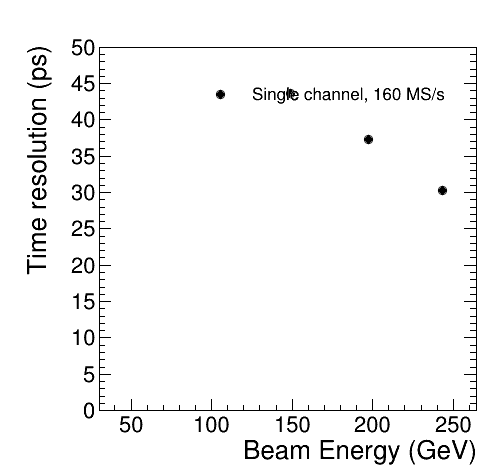

In [13]:
c1 = ROOT.TCanvas("c","c",500,500)
c1.SetTickx(0)


gres = ROOT.TGraphErrors(len(energies_float), energies_float , cm_res, energies_float_e, cm_e_res)
gres.SetTitle(";Beam Energy (GeV); Time resolution (ps)")
gres.Draw("AP")
gres.GetXaxis().SetNdivisions(507)
gres.GetYaxis().SetRangeUser(0, 50)
gres.Draw("AP")
st = gres.GetListOfFunctions().FindObject("stats")
#st.Delete()
lg = ROOT.TLegend(0.38, 0.7, 0.9, 0.9)
lg.AddEntry(gres, "Single channel, 160 MS/s", "p")
lg.SetFillStyle(-1)
lg.SetBorderSize(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.Draw("same")
c1.Draw()

c1.SetTopMargin(0.1)
c1.Draw()
c1.SaveAs('%s/time_res_%s.pdf'%(plot_folder,outstr))
c1.SaveAs('%s/time_res_%s.png'%(plot_folder,outstr))


## Plot time differences

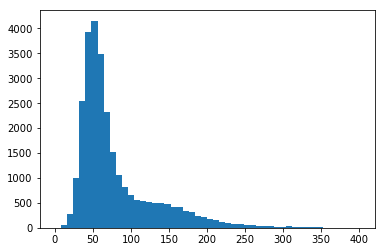

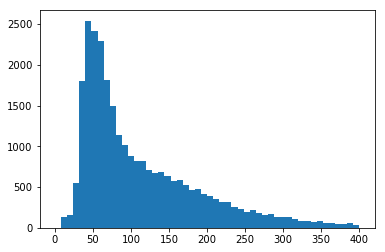

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/bin/start_ipykernel.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


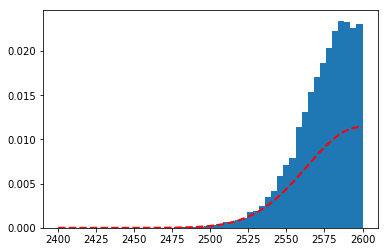

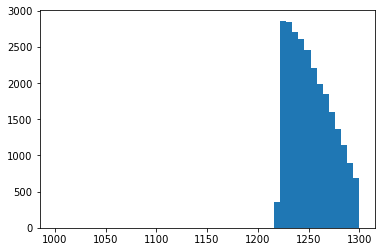

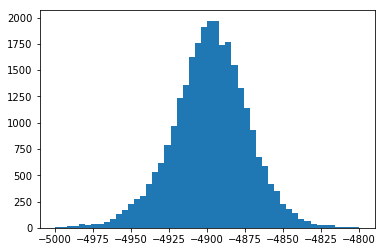

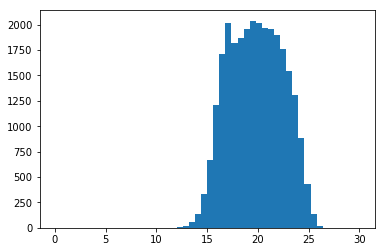

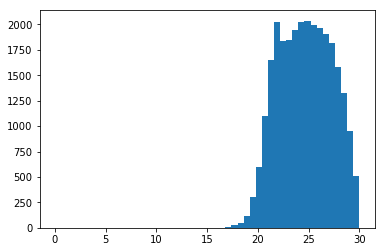

In [12]:
df = dict_df_energy[energies[0]]
plt.hist(list(df['fit_ampl_MCP1']),bins=50,range=[0,400])
plt.show()
plt.hist(list(df['fit_ampl_MCP2']),bins=50,range=[0,400])
plt.show()


from scipy.stats import norm
import matplotlib.mlab as mlab
#val = list(df.loc[(df.dt_ecal_mcp1_C3>2400) & (df.dt_ecal_mcp1_C3<2600)]['dt_ecal_mcp1_C3'])
val = list(df['dt_ecal_mcp1_C3'])

n,bins,_ = plt.hist(val,bins=50,range=[2400,2600],normed=1)
# best fit of data
(mu, sigma) = norm.fit(val,loc=2482.814488891773,scale=30.)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.show()


plt.hist(list(df['dt_ecal_mcp2_C3']),bins=50,range=[1000,1300])
plt.show()
plt.hist(list(df['dt_mcp2_mcp1_C3']),bins=50,range=[-5000,-4800])
plt.show()
plt.hist(list(df['fit_time_MCP2']),bins=50,range=[0,30])
plt.show()
plt.hist(list(df['fit_time_MCP1']),bins=50,range=[0,30])
plt.show()


In [15]:
for energy in energies:
    df = dict_df_energy[energy]
    print "dt1 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp1_C3'].mean(),df['dt_ecal_mcp1_C3'].std(),(df['dt_ecal_mcp1_C3'].quantile(0.75)-df['dt_ecal_mcp1_C3'].quantile(0.25))/2)
    print "dt2 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp2_C3'].mean(),df['dt_ecal_mcp2_C3'].std(),(df['dt_ecal_mcp2_C3'].quantile(0.75)-df['dt_ecal_mcp2_C3'].quantile(0.25))/2)
    print "dt12MCP : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_mcp2_mcp1_C3'].mean(),df['dt_mcp2_mcp1_C3'].std(),(df['dt_mcp2_mcp1_C3'].quantile(0.75)-df['dt_mcp2_mcp1_C3'].quantile(0.25))/2)
    print 

dt1 : energy 49.99, mean = 2598.336, std = 35.005, (75%                        )/2 = 21.441
dt2 : energy 49.99, mean = 1258.424, std = 29.921, (75%                        )/2 = 18.989
dt12MCP : energy 49.99, mean = -4898.087, std = 25.468, (75%                        )/2 = 15.570

dt1 : energy 99.83, mean = 2618.866, std = 69.135, (75%                        )/2 = 42.582
dt2 : energy 99.83, mean = 1294.287, std = 57.695, (75%                        )/2 = 30.621
dt12MCP : energy 99.83, mean = -4913.421, std = 30.546, (75%                        )/2 = 17.537

dt1 : energy 149.12, mean = 2498.942, std = 34.066, (75%                        )/2 = 21.260
dt2 : energy 149.12, mean = 1152.446, std = 34.798, (75%                        )/2 = 22.656
dt12MCP : energy 149.12, mean = -4891.505, std = 26.073, (75%                        )/2 = 15.784

dt1 : energy 197.27, mean = 2490.104, std = 37.979, (75%                        )/2 = 23.347
dt2 : energy 197.27, mean = 1140.673, std = 40.026, (75%  